/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/rsm_helper/model_property.py:75: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  self.lats, self.lons = transform(projection, 'EPSG:4326',grid_x, grid_y)


  0%|          | 0/7 [00:00<?, ?it/s]

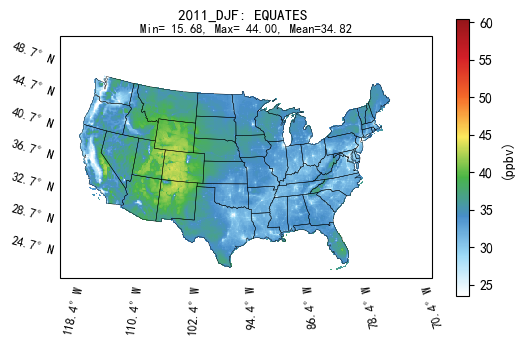

The data fusion plot for 2011_DJF: EQUATES is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_DJF: EQUATES.png


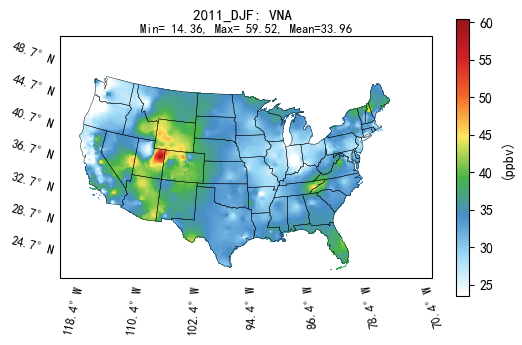

The data fusion plot for 2011_DJF: VNA is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_DJF: VNA.png


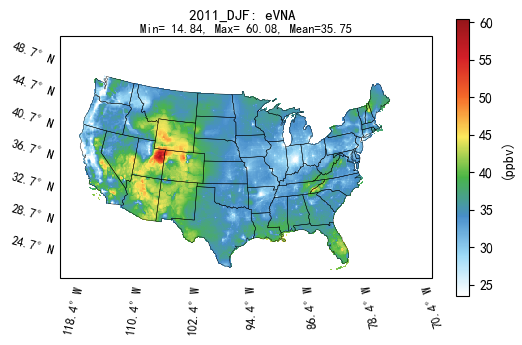

The data fusion plot for 2011_DJF: eVNA is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_DJF: eVNA.png


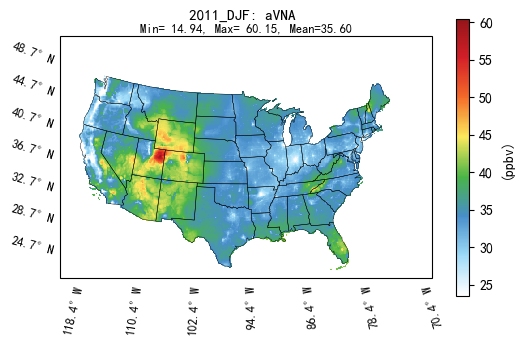

The data fusion plot for 2011_DJF: aVNA is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_DJF: aVNA.png


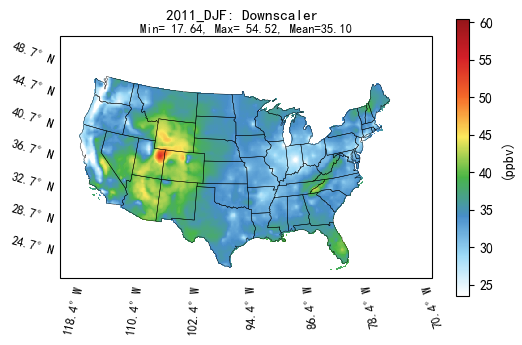

The data fusion plot for 2011_DJF: Downscaler is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_DJF: Downscaler.png


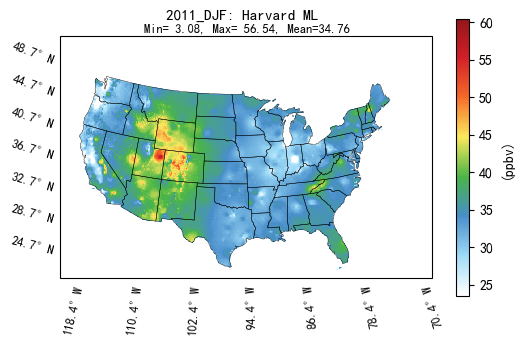

The data fusion plot for 2011_DJF: Harvard ML is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_DJF: Harvard ML.png
Image /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_top-10: EQUATES.png not found. Skipping...
Image /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_Annual: EQUATES.png not found. Skipping...
Image /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_Apr-Sep: EQUATES.png not found. Skipping...
Merged and cropped image saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/Merged/2011_DJF_merged.png
Image /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_MAM: EQUATES.png not found. Skipping...
Image /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_JJA: EQUATES.png not found. Skipping...
Image /DeepLearning/mnt/shixiansheng/data_fusion/output/2011_AloneMap/2011_SON: EQUATES.png not found. Skipping...
Done!


In [ ]:
import os
import re
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from PIL import Image

# for show maps
from esil.rsm_helper.model_property import model_attribute
from esil.map_helper import get_multiple_data, show_maps
import cmaps

cmap_conc = cmaps.WhiteBlueGreenYellowRed


def extract_key_period(period):
    key_periods = ["DJF", "MAM", "JJA", "SON", 'Annual', 'Apr-Sep', 'top-10', 'W126']
    for key in key_periods:
        if key in period:
            return key
    return None


def get_year(filename):
    match = re.search(r"(20[1-2][0-9])", filename)
    if match:
        return match.group(1)
    return None


def get_dataset_label(variable, filename):
    if variable == 'vna_ozone':
        return "VNA"
    elif variable == 'evna_ozone':
        return "eVNA"
    elif variable == 'avna_ozone':
        return "aVNA"
    elif variable == 'ds_ozone':
        return "Downscaler"
    elif variable =='model':
        return "EQUATES"
    elif variable == 'harvard_ml':
        return "Harvard ML"
    elif variable == 'SD':
        return "Standard Deviation"
    elif variable == 'CV':
        return "Coefficient of Variation"
    return "unknown"


def crop_colorbar(image):
    """裁剪掉图片右侧颜色条"""
    width, height = image.size
    # 这里假设颜色条宽度占图片宽度的1/6，可根据实际情况调整
    new_width = int(width * 5 / 6)
    return image.crop((0, 0, new_width, height))


def crop_left(image, left_crop_pixels):
    """裁剪图片左侧"""
    width, height = image.size
    left = left_crop_pixels
    return image.crop((left, 0, width, height))


def plot_us_map(
        fusion_output_file,
        model_file,
        base_save_path=None,
        boundary_json_file="/DeepLearning/mnt/Devin/boundary/USA_State.json",
        variable_settings=None,
        key_periods=None,
        merge_enabled=True,
        merge_combinations=[],
        merge_config=None
):
    # 设置合并配置的默认值
    if merge_config is None:
        merge_config = {
            "gap": -10,
            "top_crop_pixels": 400,
            "bottom_crop_pixels": 400,
            "left_crop_pixels": 250,
            "right_crop_pixels": 200,
            "subplot_left_crop": 100
        }
    gap = merge_config["gap"]
    top_crop_pixels = merge_config["top_crop_pixels"]
    bottom_crop_pixels = merge_config["bottom_crop_pixels"]
    overall_left_crop = merge_config["left_crop_pixels"]
    right_crop_pixels = merge_config["right_crop_pixels"]
    subplot_left_crop = merge_config["subplot_left_crop"]

    mp = model_attribute(model_file)
    proj, longitudes, latitudes = mp.projection, mp.lons, mp.lats
    df_data = pd.read_csv(fusion_output_file)
    if "Period" not in df_data.columns:
        print("The data fusion file does not contain the Period column!")
        return

    year = get_year(fusion_output_file)
    if not year:
        print("Could not extract year from the filename.")
        return

    save_path = os.path.join("/DeepLearning/mnt/shixiansheng/data_fusion/output", f"{year}_AloneMap")
    merged_path = os.path.join("/DeepLearning/mnt/shixiansheng/data_fusion/output", "Merged")
    try:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            print(f"Created directory: {save_path}")
        if not os.path.exists(merged_path):
            os.makedirs(merged_path)
            print(f"Created directory: {merged_path}")
    except OSError as e:
        print(f"Error creating directory: {e}")
        return

    layout = None
    periods = df_data["Period"].unique()
    available_periods = [extract_key_period(period) for period in periods if extract_key_period(period)]

    for period in tqdm(periods):
        key_period = extract_key_period(period)
        if key_periods and key_period not in key_periods:
            continue

        df_period = df_data[df_data["Period"] == period]
        period_label = f"{year}_{key_period}" if key_period else f"{year}"
        period = (
            period.replace("_daily_DF", "")
           .replace("average", "Avg.")
           .replace("Average", "Avg.")
        )

        for variable in variable_settings['variables']:
            if variable not in df_period.columns:
                print(f"Variable {variable} not found in data for period {period}. Skipping...")
                continue

            grid_concentration = df_period[variable].values.reshape(longitudes.shape)

            value_range = variable_settings['settings'].get('value_range')

            if value_range is None:
                vmax_conc = np.nanpercentile(grid_concentration, 99.5)
                vmin_conc = np.nanpercentile(grid_concentration, 0.5)
                value_range = (vmin_conc, vmax_conc)

            dataset_label = get_dataset_label(variable, fusion_output_file)
            title = f"{period_label}: {dataset_label}"

            dict_data = {}
            get_multiple_data(
                dict_data,
                dataset_name=title,
                variable_name="",
                grid_x=longitudes,
                grid_y=latitudes,
                grid_concentration=grid_concentration
            )

            fig = show_maps(
                dict_data,
                unit=variable_settings['settings'].get('unit', "ppbv"),
                cmap=variable_settings['settings'].get('cmap_conc', cmap_conc),
                show_lonlat=variable_settings['settings'].get('show_lonlat', False),
                projection=proj,
                is_wrf_out_data=variable_settings['settings'].get('is_wrf_out_data', True),
                boundary_file=boundary_json_file,
                show_original_grid=variable_settings['settings'].get('show_original_grid', True),
                panel_layout=variable_settings['settings'].get('panel_layout', layout),
                title_fontsize=variable_settings['settings'].get('title_fontsize', 11),
                xy_title_fontsize=variable_settings['settings'].get('xy_title_fontsize', 9),
                show_dependenct_colorbar=variable_settings['settings'].get('show_dependenct_colorbar', True),
                value_range=value_range,
                show_domain_mean=variable_settings['settings'].get('show_domain_mean', True),
                show_grid_line=variable_settings['settings'].get('show_grid_line', True)
            )

            if save_path is not None:
                save_file = os.path.join(save_path, f"{title}.png")
                fig.savefig(save_file, dpi=300)
                print(f"The data fusion plot for {title} is saved to {save_file}")

    if merge_enabled:
        if not merge_combinations:
            merge_combinations = [[period] for period in available_periods]

        for combination in merge_combinations:
            # 检查组合中的所有周期是否都有可用数据
            if not all(period in available_periods for period in combination):
                print(f"Skipping combination {combination} as some periods are not available.")
                continue

            for period in combination:
                images = []
                period_label = f"{year}_{period}"
                for variable in ['model', 'vna_ozone', 'evna_ozone', 'avna_ozone', 'ds_ozone', 'harvard_ml']:
                    dataset_label = get_dataset_label(variable, fusion_output_file)
                    title = f"{period_label}: {dataset_label}"
                    image_path = os.path.join(save_path, f"{title}.png")
                    if os.path.exists(image_path):
                        img = Image.open(image_path)
                        # 裁剪颜色条
                        img = crop_colorbar(img)
                        # 裁剪子图左侧
                        img = crop_left(img, subplot_left_crop)
                        images.append(img)
                    else:
                        print(f"Image {image_path} not found. Skipping...")
                        break
                else:
                    if images:
                        total_width = sum([img.width for img in images]) + (len(images) - 1) * gap
                        max_height = max([img.height for img in images])

                        merged_image = Image.new('RGB', (total_width, max_height), color=(255, 255, 255))
                        x_offset = 0
                        for img in images:
                            merged_image.paste(img, (x_offset, 0))
                            x_offset += img.width + gap

                        width, height = merged_image.size
                        left = overall_left_crop
                        upper = top_crop_pixels
                        right = width - right_crop_pixels
                        lower = height - bottom_crop_pixels
                        cropped_image = merged_image.crop((left, upper, right, lower))

                        # 保存合并后的图片到 Merged 文件夹
                        merged_image_path = os.path.join(merged_path, f"{year}_{period}_merged.png")
                        cropped_image.save(merged_image_path)
                        print(f"Merged and cropped image saved to {merged_image_path}")


if __name__ == "__main__":
    model_file = r"/backupdata/data_EPA/EQUATES/EQUATES_data/HR2DAY_LST_ACONC_v532_cb6r3_ae7_aq_WR413_MYR_STAGE_2011_12US1_2011.nc"
    file_list = ["/DeepLearning/mnt/shixiansheng/data_fusion/output/Data_WithoutCV/2002_Data_WithoutCV_Metrics.csv"]

    # special metrics
    key_periods = ['DJF']
    # key_periods = ['W126']
    # key_periods = ['DJF', 'MAM', 'JJA', 'SON', 'Annual', 'Apr-Sep', 'top-10']

    common_settings = {
        'unit': "ppbv",
        'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
        'show_lonlat': False,
        'is_wrf_out_data': True,
        'show_original_grid': True,
        'panel_layout': None,
        'title_fontsize': 11,
        'xy_title_fontsize': 9,
        'show_dependenct_colorbar': True,
        'show_domain_mean': True,
        'show_grid_line': None,
        'value_range': (23.5, 60.5),
        # 'value_range': (None,None),
    }

    variable_settings = {
        'variables': ['model', 'vna_ozone', 'evna_ozone', 'avna_ozone', 'ds_ozone', 'harvard_ml'],
        # 'variables': ['model'],
      'settings': common_settings
    }

    merge_enabled = True
    merge_combinations = []
    merge_config = {
        "gap": -152,
        "top_crop_pixels": 420,
        "bottom_crop_pixels": 270,
        "left_crop_pixels": 0,
        "right_crop_pixels": 110,
        "subplot_left_crop": 61  # 可根据实际情况调整子图左边裁剪像素
    }

    for file in file_list:
        plot_us_map(file, model_file, variable_settings=variable_settings, key_periods=key_periods,
                    merge_enabled=merge_enabled, merge_combinations=merge_combinations,
                    merge_config=merge_config)
    print("Done!")
    